In [1]:
import os, math, glob, re
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from kaggle_datasets import KaggleDatasets

from tensorflow.keras import layers
import tensorflow as tf

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8


# Set Constants

In [3]:
mri_types = ['FLAIR','T1w','T1wCE','T2w']
IMAGE_SIZE  = 128
IMAGE_DEPTH = 32
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
CHANNELS  = len(mri_types)

AUTO = tf.data.AUTOTUNE

In [4]:
GCS_PATH = KaggleDatasets().get_gcs_path("rsna-brain-tumor-classification-tfrecords")
tf_train_path = GCS_PATH + "/tfrecords/train"
tf_valid_path = GCS_PATH + "/tfrecords/valid"

# Read TFRecords and Create Dataset

I have converted Original dataset with [this](https://www.kaggle.com/kavehshahhosseini/rsna-brain-tumor-convert-dicom-to-tfrecord) notebook to TFRecords and I have created a new dataset, which you can find it [here](https://www.kaggle.com/kavehshahhosseini/rsna-brain-tumor-classification-tfrecords). You should add the converted dataset, to the notebook to go further. I have splitted the data to train with 465 samples and each of them with shape `(128,128,32,4)` and validation data with 117 samples and the same shape.  

In [5]:
def deserialize_example(serialized_string):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'MGMT_value': tf.io.FixedLenFeature([], tf.float32)
    }
    parsed_record = tf.io.parse_single_example(serialized_string, image_feature_description)
    image = tf.io.decode_raw(parsed_record['image'], tf.float64)
    image = tf.reshape(image,[IMAGE_SIZE,IMAGE_SIZE,IMAGE_DEPTH,CHANNELS])
    
    label = parsed_record['MGMT_value']
    return image, label

In [6]:
train_set = tf.data.TFRecordDataset(str(tf_train_path + os.sep + "brain_train.tfrec"),
                                   compression_type="GZIP", num_parallel_reads=AUTO).map(deserialize_example).batch(BATCH_SIZE).prefetch(AUTO)
valid_set = tf.data.TFRecordDataset(str(tf_valid_path + os.sep + "brain_val.tfrec"),
                                   compression_type="GZIP", num_parallel_reads=AUTO).map(deserialize_example).batch(BATCH_SIZE).prefetch(AUTO)

# Visualize Image

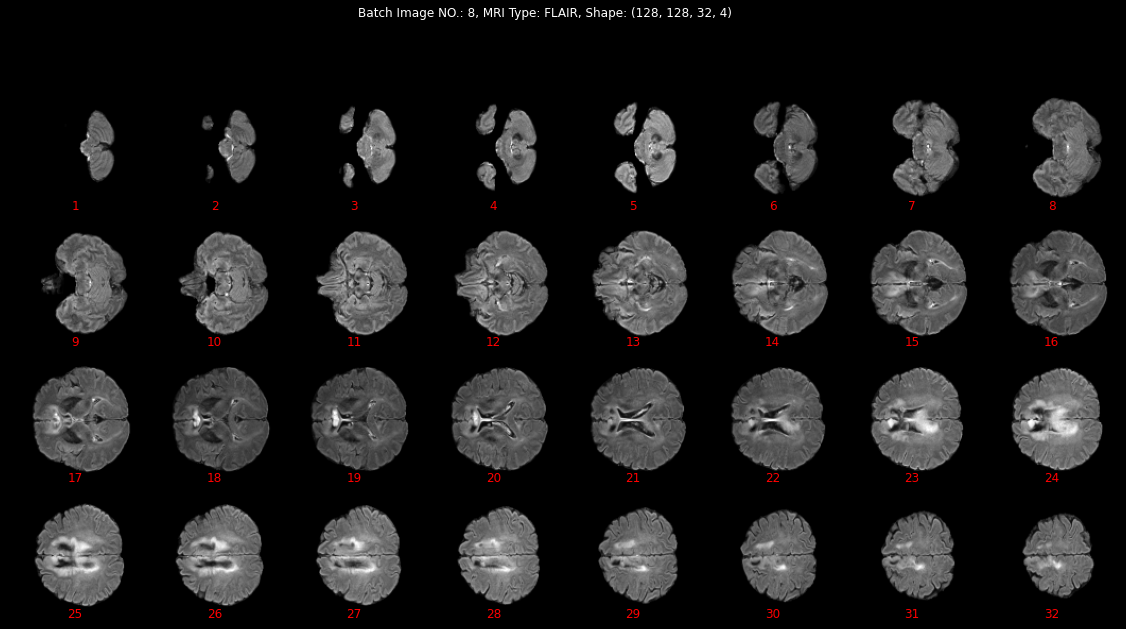

In [7]:
d = train_set.take(1)
for i, j in d:
    image = i
    label = j


img_id = np.random.randint(0, BATCH_SIZE)
channel = np.random.randint(0,CHANNELS)

plt.figure(figsize=(20,10),facecolor=(0,0,0))
cols = IMAGE_DEPTH//4
rows = 4

plt.axis("off")
for layer_idx in range(IMAGE_DEPTH):
    ax = plt.subplot(rows,cols,layer_idx+1)
    ax.imshow(np.squeeze(image[img_id,:,:,layer_idx,channel]), cmap="gray")
    ax.axis("off")
    ax.set_title(str(layer_idx+1),color='r',y=-0.01)
    
plt.suptitle(f"Batch Image NO.: {img_id}, MRI Type: {mri_types[channel]}, Shape: {image[img_id].shape}", color="w")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Create Model

In [8]:
def get_model(width=128, height=128, depth=32):

    inputs = tf.keras.Input((width, height, depth, 4))

    x = layers.Conv3D(filters=32, kernel_size=2, activation="relu", padding="same")(inputs)
    x = layers.MaxPool3D(2)(x)

    x = layers.Conv3D(filters=64, kernel_size=2, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(2)(x)

    x = layers.Conv3D(filters=128, kernel_size=2, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(2)(x)
    
    x = layers.Conv3D(filters=256, kernel_size=2, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(2)(x)
    
    x = layers.Conv3D(filters=512, kernel_size=2, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dense(units=128, activation="relu")(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)

    return model


with strategy.scope():
    model = get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=IMAGE_DEPTH)
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy", "AUC"])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 32, 4)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 128, 32, 32)  1056      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 16, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 16, 64)    16448     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 32, 8, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 32, 8, 128)    65664     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 16, 16, 4, 128)    0     

# Train Model

In [9]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)
history = model.fit(train_set, validation_data=valid_set, epochs=10, callbacks=[early_stopping_cb])

Epoch 1/10
4/4 [==============================] - 52s 12s/step - loss: 0.6973 - accuracy: 0.4828 - auc: 0.4757 - val_loss: 0.6938 - val_accuracy: 0.5299 - val_auc: 0.5720
Epoch 2/10
4/4 [==============================] - 39s 10s/step - loss: 0.6948 - accuracy: 0.5260 - auc: 0.5107 - val_loss: 0.6874 - val_accuracy: 0.5299 - val_auc: 0.6172
Epoch 3/10
4/4 [==============================] - 38s 10s/step - loss: 0.6891 - accuracy: 0.5260 - auc: 0.5712 - val_loss: 0.6884 - val_accuracy: 0.5299 - val_auc: 0.6182
Epoch 4/10
4/4 [==============================] - 38s 10s/step - loss: 0.6908 - accuracy: 0.5260 - auc: 0.5626 - val_loss: 0.6855 - val_accuracy: 0.5641 - val_auc: 0.6007
Epoch 5/10
4/4 [==============================] - 38s 10s/step - loss: 0.6864 - accuracy: 0.5371 - auc: 0.5732 - val_loss: 0.6857 - val_accuracy: 0.5556 - val_auc: 0.6133
Epoch 6/10
4/4 [==============================] - 38s 10s/step - loss: 0.6868 - accuracy: 0.5515 - auc: 0.5871 - val_loss: 0.6783 - val_accuracy:

# Plot Model Metrics

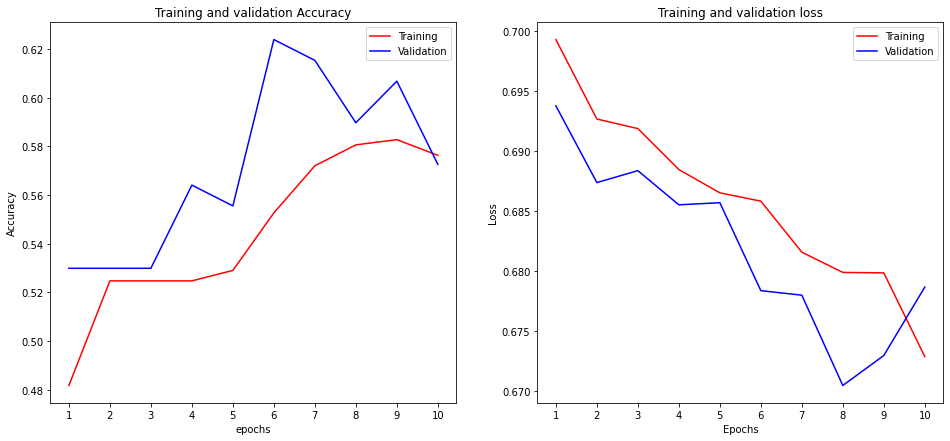

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1) # Get number of epochs
ax1 = plt.subplot(1,2,1)
ax1.plot(epochs, acc, 'r')
ax1.plot(epochs, val_acc, 'b')
ax1.set_xticks([i for i in epochs])
ax1.set_title('Training and validation Accuracy')
ax1.legend(["Training", "Validation" ])
ax1.set_xlabel("epochs")
ax1.set_ylabel("Accuracy")

ax2 = plt.subplot(1,2,2)
ax2.plot(epochs, loss, 'r')
ax2.plot(epochs, val_loss, 'b')
ax2.set_xticks([i for i in epochs])
ax2.legend(["Training", "Validation" ])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title('Training and validation loss')

plt.show()

In [11]:
model.save("my_simple_model_v2.h5")

# Prediction and Submission

I have created another kernel for prediction 